In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.models import Sequential
from keras.optimizers import SGD
from sklearn.metrics import mean_squared_error
import math

import warnings
warnings.filterwarnings("ignore")

sns.set(rc={"axes.facecolor":"Beige" , "axes.grid" : False})

2024-06-27 12:49:11.315679: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-27 12:49:11.315842: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-27 12:49:11.484769: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Load the dataset
data_url = '/kaggle/input/indian-energy-stock-price-data/Torrent Power Limited (TORNTPOWER.BO).csv'
df = pd.read_csv(data_url, parse_dates=['Date'], dayfirst=True)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2008-01-02,191.000000,196.399994,187.100006,190.500000,154.588120,165112.0
1,2008-01-03,190.000000,228.600006,188.649994,228.600006,185.505737,2655358.0
2,2008-01-04,238.600006,269.899994,234.399994,250.500000,203.277298,3489837.0
3,2008-01-07,246.699997,250.000000,232.500000,236.600006,191.997650,1062232.0
4,2008-01-08,240.000000,242.500000,209.949997,214.600006,174.144897,810699.0


In [3]:
df['Date'] = pd.to_datetime(df['Date'])

In [4]:
df = df.dropna(how='all')

In [5]:
# Ensure the index is unique by removing duplicate dates
df = df[~df['Date'].duplicated(keep='first')]

In [6]:
# Set the date column as the index
df = df.set_index('Date')
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-01-02,191.000000,196.399994,187.100006,190.500000,154.588120,165112.0
2008-01-03,190.000000,228.600006,188.649994,228.600006,185.505737,2655358.0
2008-01-04,238.600006,269.899994,234.399994,250.500000,203.277298,3489837.0
2008-01-07,246.699997,250.000000,232.500000,236.600006,191.997650,1062232.0
2008-01-08,240.000000,242.500000,209.949997,214.600006,174.144897,810699.0


In [7]:
# Resample the data to a weekly frequency
df_weekly = df.resample('W').mean()
df_weekly.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-01-06,206.533335,231.633331,203.383331,223.200002,181.123718,2.103436e+06
2008-01-13,225.189999,233.290002,208.910001,215.830002,175.143054,1.071410e+06
2008-01-20,205.389999,212.759998,198.030002,203.689999,165.291614,5.580932e+05
2008-01-27,171.779999,182.000000,154.329999,166.879999,135.420799,4.000658e+05
2008-02-03,180.639999,182.839999,168.300000,174.679996,141.750400,1.861792e+05


In [8]:
# Separate the last 10 weeks for testing
test_data = df_weekly[-10:]
df_weekly = df_weekly[:-10]

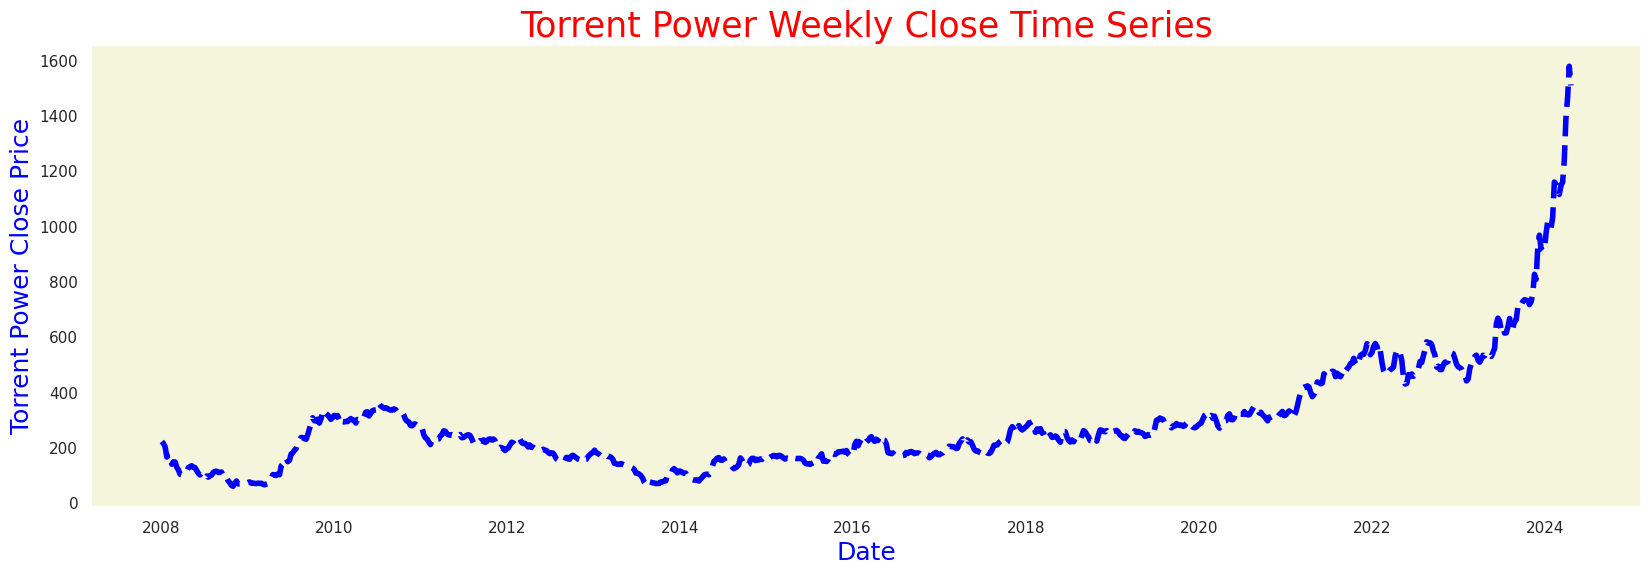

In [9]:
# Plot the time series of Torrent Power
plt.figure(figsize=(20, 6))
plt.plot(df_weekly.index, df_weekly['Close'],lw=4,color='Blue', ls='--')
plt.title('Torrent Power Weekly Close Time Series',fontsize=25,color='Red')
plt.xlabel('Date',fontsize=18,color='Blue')
plt.ylabel('Torrent Power Close Price',fontsize=18,color='Blue')
plt.show()

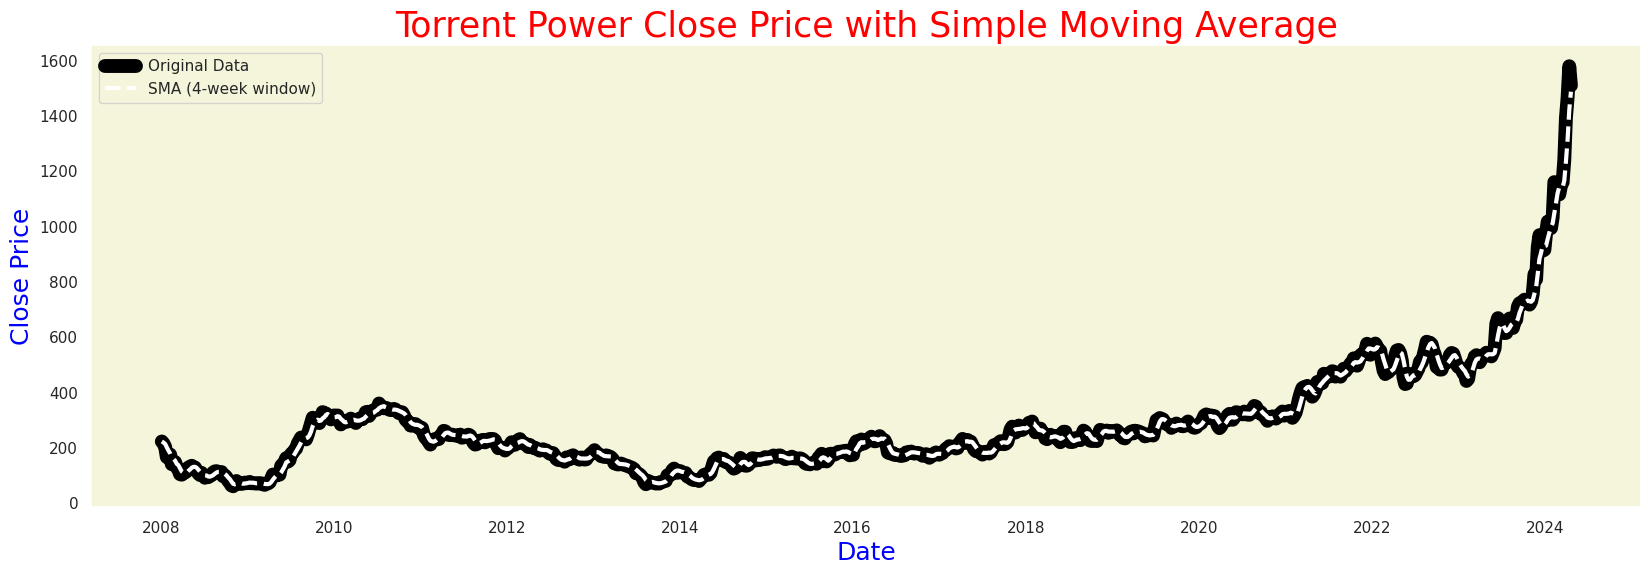

In [10]:
# Calculate a simple moving average with window size 4 (adjust as needed)
window_size = 4
df_weekly['SMA'] = df_weekly['Close'].rolling(window=window_size, min_periods=1).mean()

# Plot the original data and the moving average
plt.figure(figsize=(20, 6))
plt.plot(df_weekly.index, df_weekly['Close'], label='Original Data',lw= 10, color= 'Black')
plt.plot(df_weekly.index, df_weekly['SMA'], label=f'SMA ({window_size}-week window)',lw= 3, color= 'white', ls='--')
plt.title('Torrent Power Close Price with Simple Moving Average',fontsize=25,color='Red')
plt.xlabel('Date',fontsize=18,color='Blue')
plt.ylabel('Close Price',fontsize=18,color='Blue')
plt.legend()
plt.show()

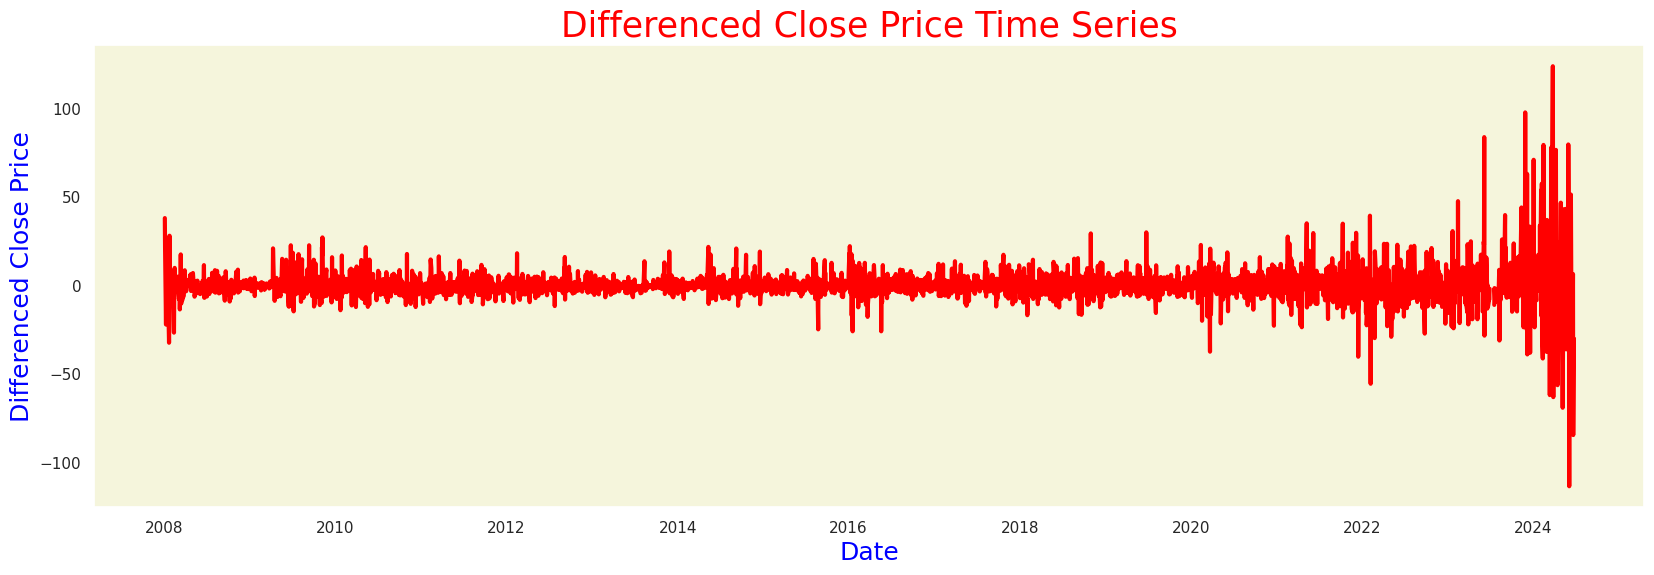

In [11]:
# Take first-order difference to make the series stationary
df['Diff_Close'] = df['Close'].diff()

# Plot the differenced series
plt.figure(figsize=(20, 6))
plt.plot(df.index, df['Diff_Close'],label='Diff_Close',lw= 3, color= 'Red')
plt.title('Differenced Close Price Time Series',fontsize=25,color='Red')
plt.xlabel('Date',fontsize=18,color='Blue')
plt.ylabel('Differenced Close Price',fontsize=18,color='Blue')
plt.show()

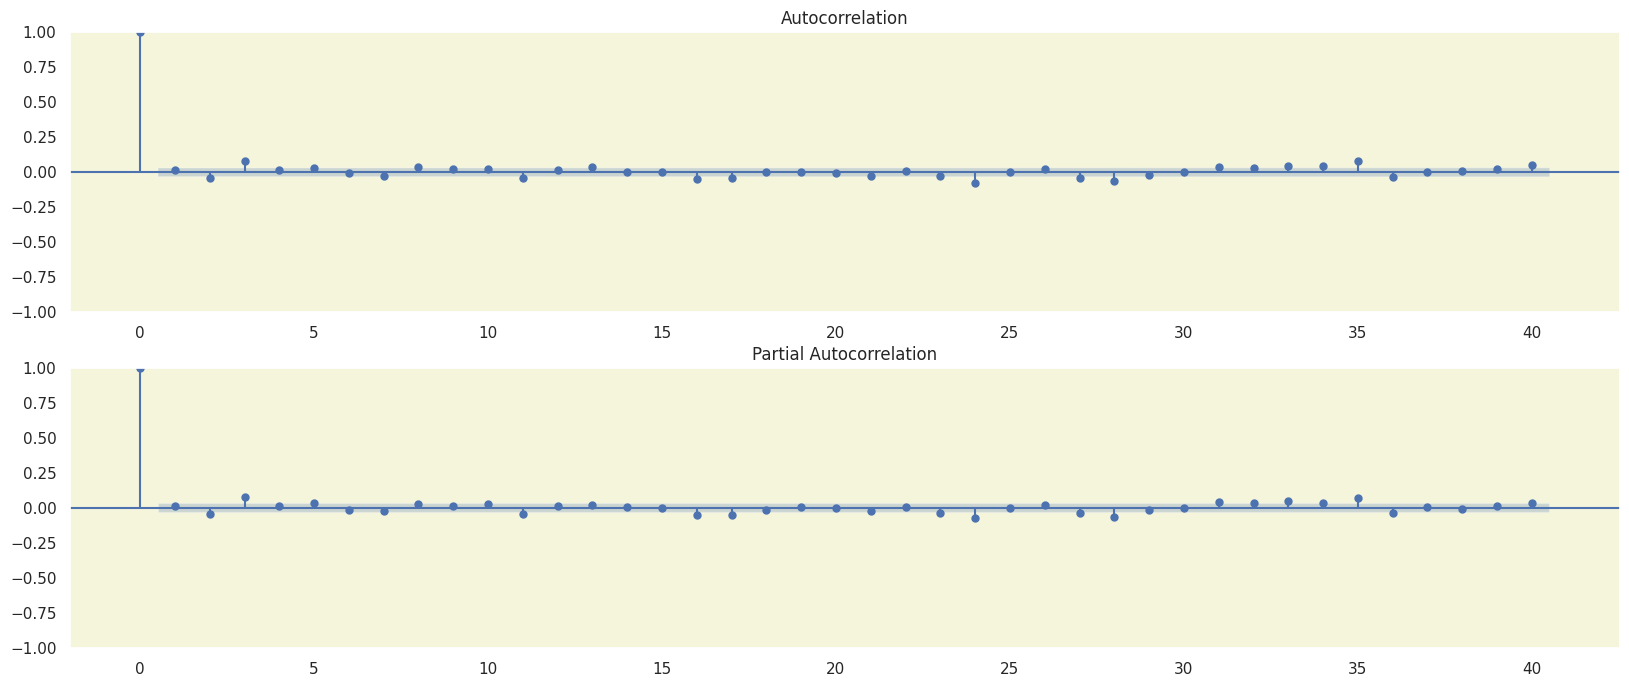

In [12]:
# Plot ACF and PACF of the differenced series
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 8))
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(df['Diff_Close'].dropna(), lags=40, ax=ax1)
sm.graphics.tsa.plot_pacf(df['Diff_Close'].dropna(), lags=40, ax=ax2)
plt.show()

In [13]:
df = df.dropna(how='all')

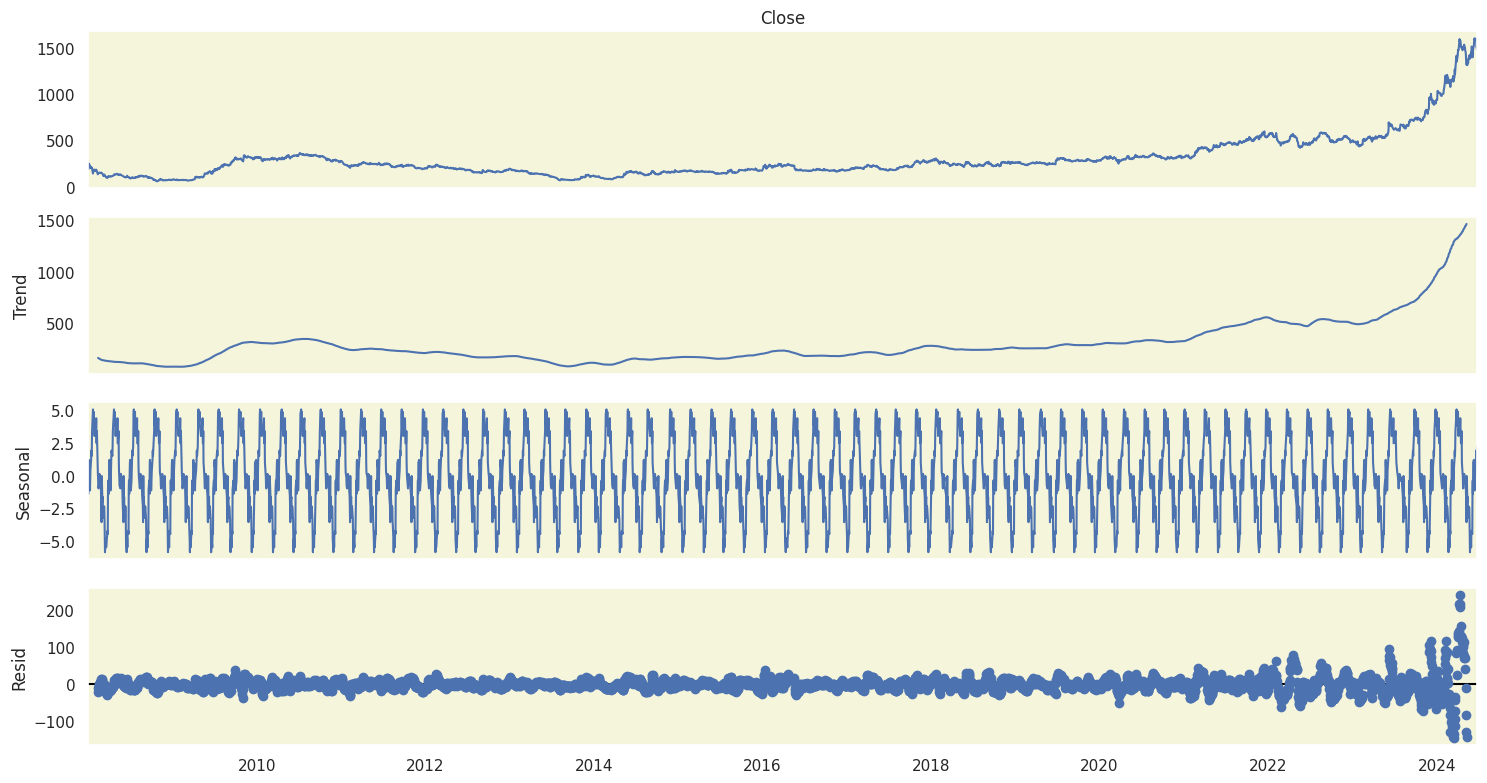

In [14]:
plt.rcParams["figure.figsize"] = (15,8)
from statsmodels.tsa.seasonal import seasonal_decompose
from itertools import product
decomp=seasonal_decompose(df['Close'], model='additive', period=60)
decomp.plot()
plt.show()

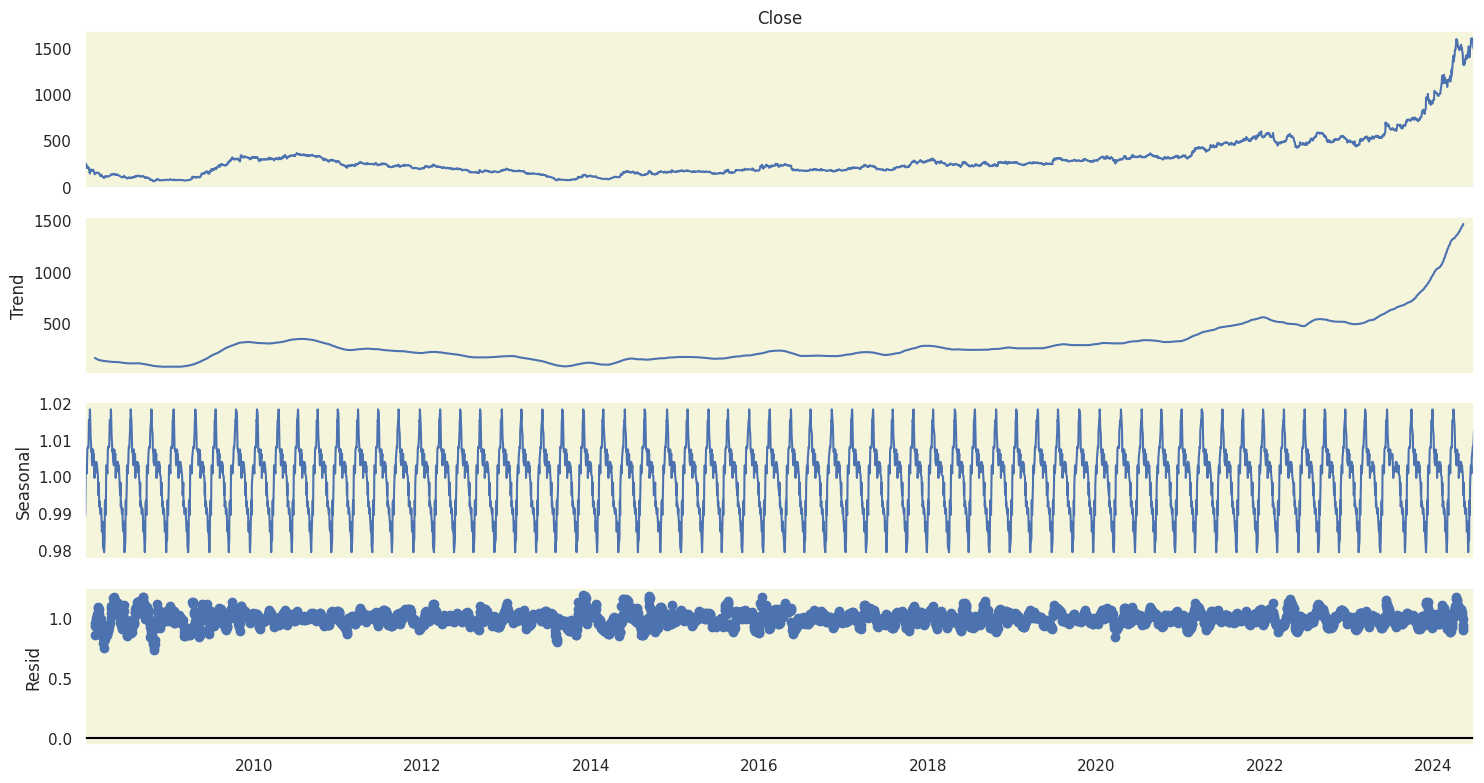

In [15]:
plt.rcParams["figure.figsize"] = (15,8)
from statsmodels.tsa.seasonal import seasonal_decompose
from itertools import product
decomp=seasonal_decompose(df['Close'], model='multiplicative', period=60)
decomp.plot()
plt.show()

In [16]:
y = df['Close'].resample('MS').mean()
y.head()

Date
2008-01-01    195.729545
2008-02-01    154.676190
2008-03-01    114.952778
2008-04-01    119.265000
2008-05-01    128.687500
Freq: MS, Name: Close, dtype: float64

In [17]:
train = y[:'2023']
test = y['2023':]

In [18]:
# Hyperparameter Tuning using Grid Search
best_aic = float("inf")
best_order = None

p_values = range(0, 2)  # Adjusted based on data availability
d_values = range(1, 2)
q_values = range(0, 2)  # Adjusted based on data availability

for p, d, q in product(p_values, d_values, q_values):
    try:
        model = sm.tsa.ARIMA(train, order=(p, d, q))
        results = model.fit()
        aic = results.aic
        if aic < best_aic:
            best_aic = aic
            best_order = (p, d, q)
    except:
        continue

print("Best ARIMA Order:", best_order)

Best ARIMA Order: (1, 1, 1)


In [19]:
import statsmodels.api as sm

model = sm.tsa.ARIMA(train, order = (1, 1, 1), seasonal_order = (1, 0, 1, 12), 
                                  enforce_stationarity = False, enforce_invertibility = False)
fitted_model = model.fit()
print(fitted_model.summary())

                                    SARIMAX Results                                     
Dep. Variable:                            Close   No. Observations:                  192
Model:             ARIMA(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -817.919
Date:                          Thu, 27 Jun 2024   AIC                           1645.838
Time:                                  12:49:32   BIC                           1661.719
Sample:                              01-01-2008   HQIC                          1652.279
                                   - 12-01-2023                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9512      0.063     15.145      0.000       0.828       1.074
ma.L1         -0.8137      0.097     -8.382      0.

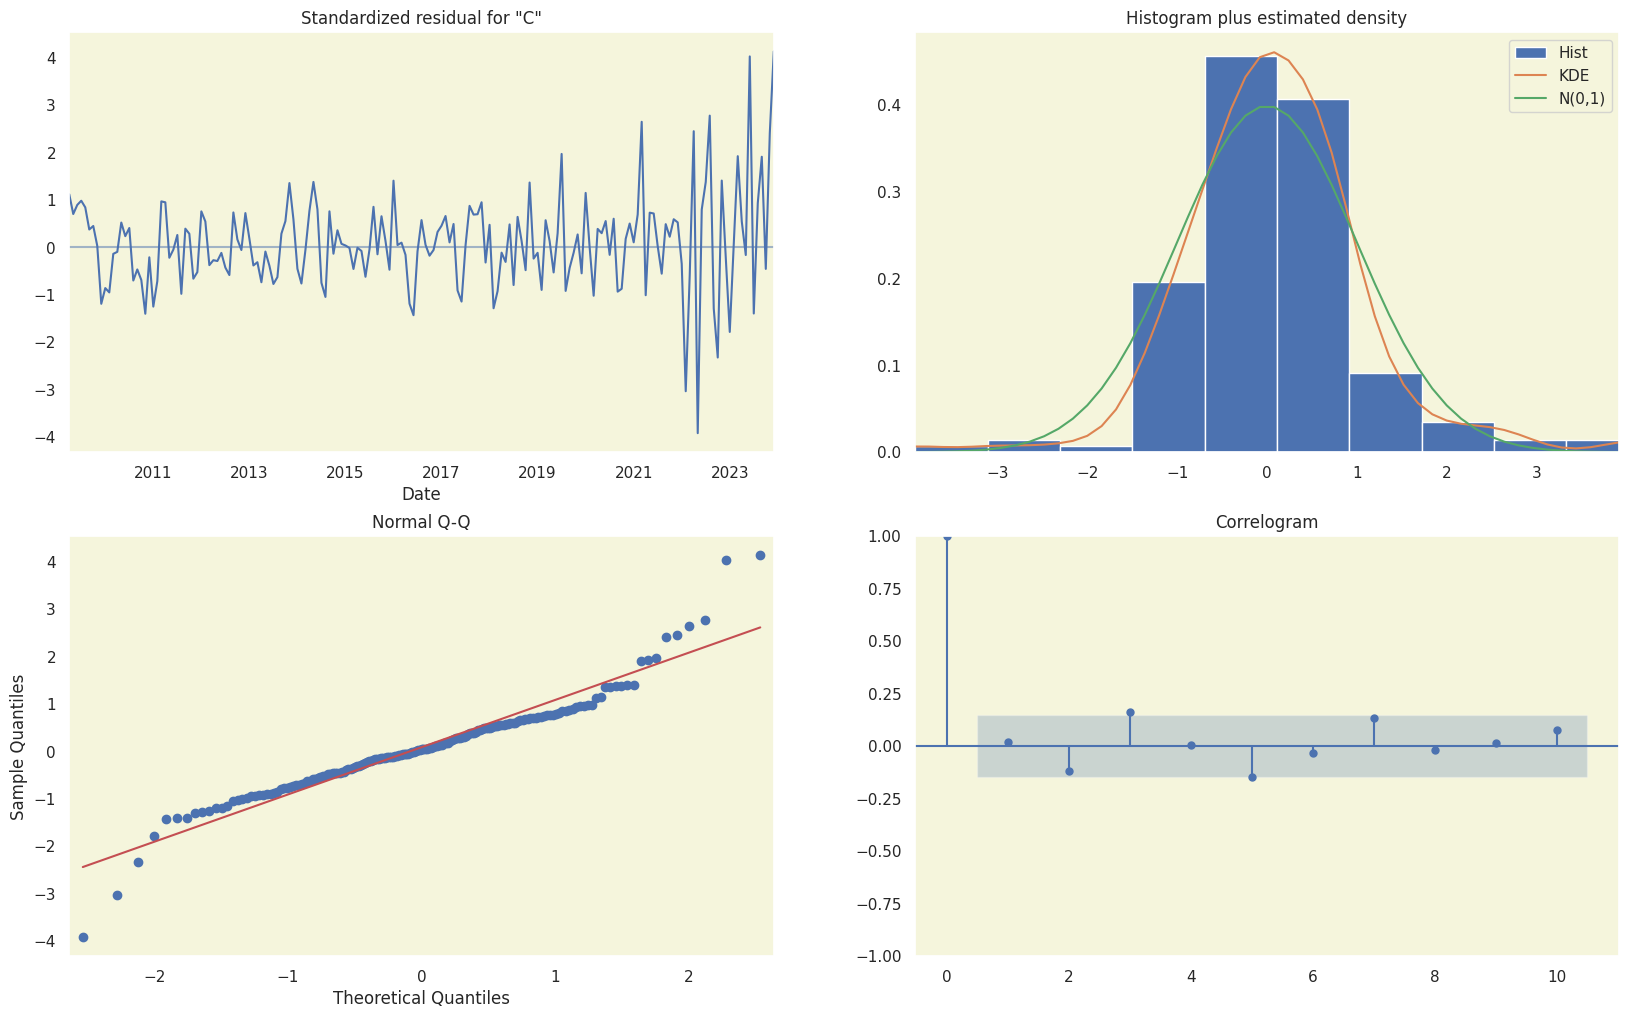

In [20]:
fitted_model.plot_diagnostics(figsize = (20, 12))
plt.show()

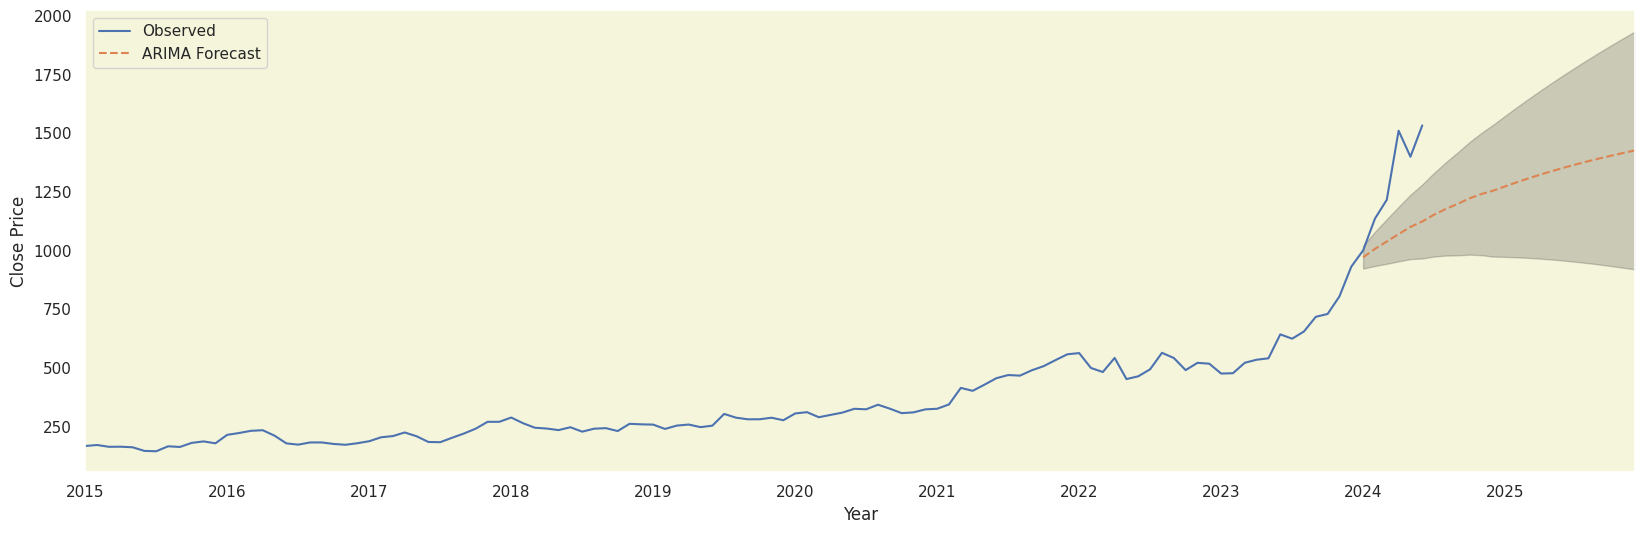

In [21]:
#Getting the ARIMA forecast with number of steps as 24 since we want to make 2 year prediction and our data is monthly sampled.
pred = fitted_model.get_forecast(steps = 24)
#Plotting the observed and forecasted values:
ax1 = y['2015':].plot(label = 'Observed')
pred.predicted_mean.plot(ax = ax1, label = 'ARIMA Forecast', figsize = (20, 6), linestyle = 'dashed')
#Finding the confidence intervals of the forecasts.
pred_ci = pred.conf_int()
ax1.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color = 'k', alpha = 0.2)
ax1.set_xlabel('Year')
ax1.set_ylabel('Close Price')
plt.legend(loc = 'upper left')
plt.show()

In [22]:
y_forecasted_ARIMA = pred.predicted_mean
y_truth = test
mse_ARIMA = ((y_forecasted_ARIMA - y_truth) ** 2).mean()
print('The Mean Squared Error of ARIMA forecast is {}'.format(round(mse_ARIMA, 2)))
print('The Root Mean Squared Error of ARIMA forecast is {}'.format(round(np.sqrt(mse_ARIMA), 2)))

The Mean Squared Error of ARIMA forecast is 83437.46
The Root Mean Squared Error of ARIMA forecast is 288.86


In [23]:
# Hyperparameter Tuning using Grid Search
best_aic = float("inf")
best_order = None

p_values = range(0, 2)  # Adjusted based on data availability
d_values = range(1, 2)
q_values = range(0, 2)  # Adjusted based on data availability

for p, d, q in product(p_values, d_values, q_values):
    try:
        model = sm.tsa.statespace.SARIMAX(train, order=(p, d, q))
        results = model.fit()
        aic = results.aic
        if aic < best_aic:
            best_aic = aic
            best_order = (p, d, q)
    except:
        continue

print("Best SARIMA Order:", best_order)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.62363D+00    |proj g|=  2.06780D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1      3      1     0     0   5.461D-07   4.624D+00
  F =   4.6236273460441586     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.6

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


In [24]:
import statsmodels.api as sm

model = sm.tsa.statespace.SARIMAX(train, order = (1, 1, 1), seasonal_order = (1, 0, 1, 12), 
                                  enforce_stationarity = False, enforce_invertibility = False)
fitted_model = model.fit(maxiter = 200, method = 'nm')
print(fitted_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                  192
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -819.311
Date:                            Thu, 27 Jun 2024   AIC                           1648.622
Time:                                    12:49:35   BIC                           1664.503
Sample:                                01-01-2008   HQIC                          1655.063
                                     - 12-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8701      0.116      7.523      0.000       0.643       1.097
ma.L1         -0.7067      0.159   

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


***Plotting Diagnostics of the Data: Diagnostic plots for standardized residuals of the surface temperatures.***

**The plot_diagnostics function produces a 2x2 plot grid with the following plots (ordered clockwise from top left):**

- Standardized residuals over time
- Histogram plus estimated density of standardized residuals, along with a Normal(0,1) density plotted for reference.
- Normal Q-Q plot, with Normal reference line.
- Correlogram

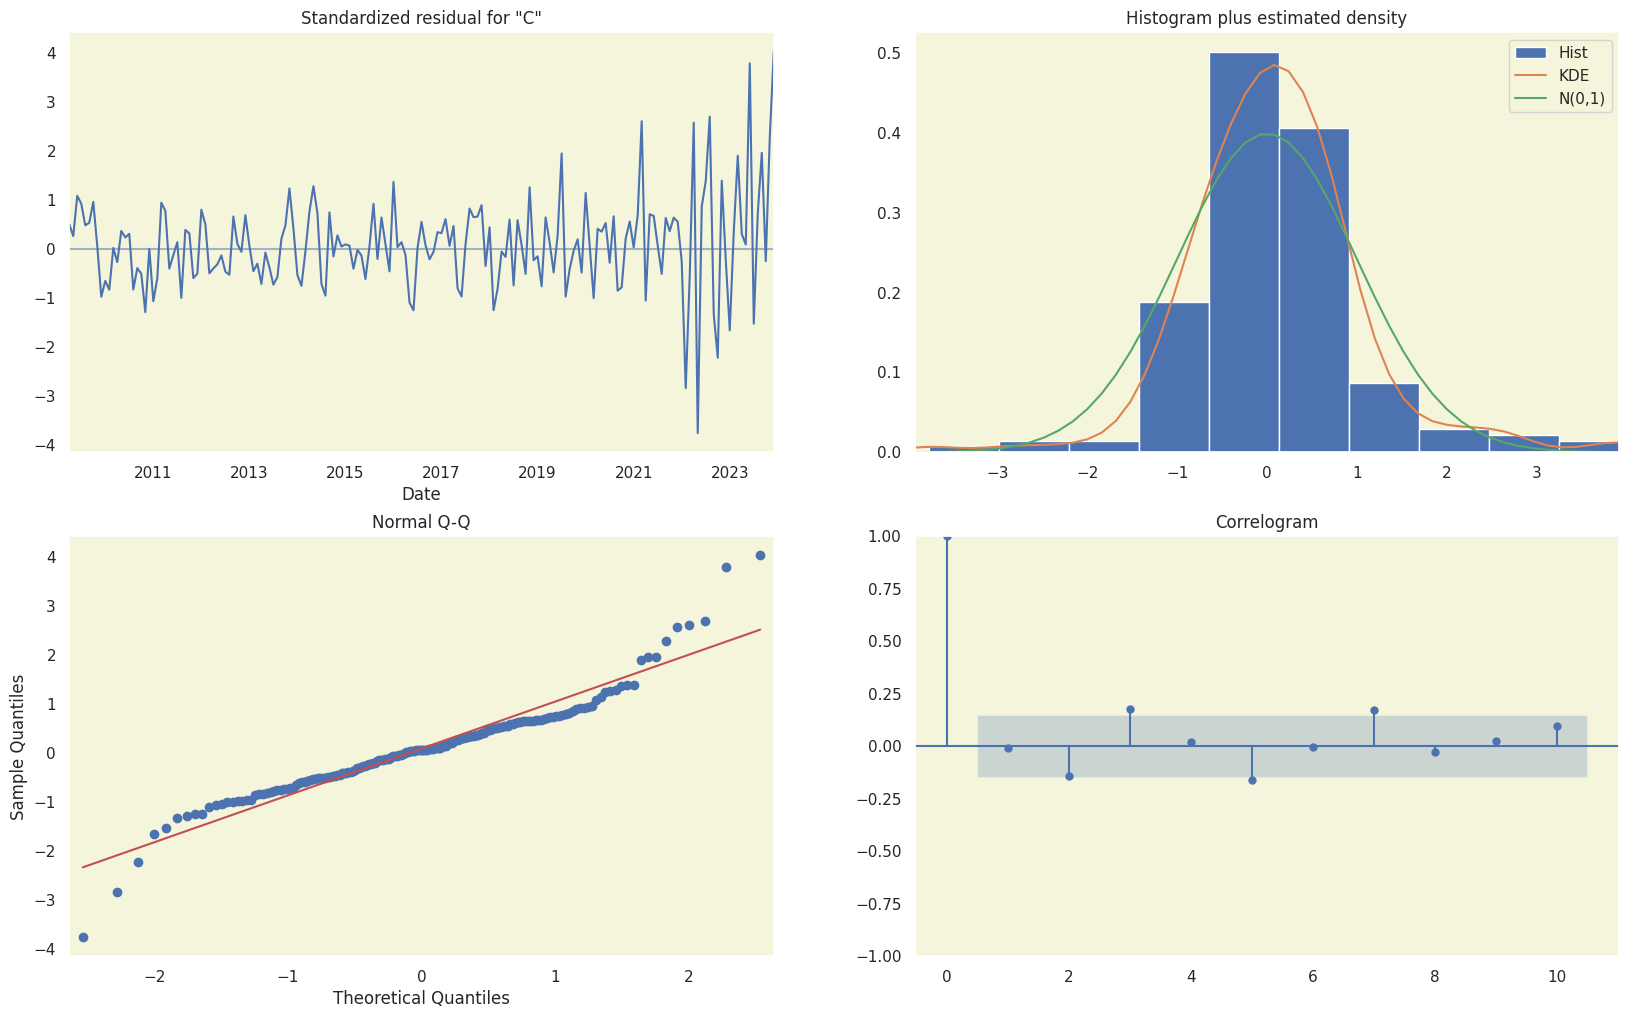

In [25]:
fitted_model.plot_diagnostics(figsize = (20, 12))
plt.show()

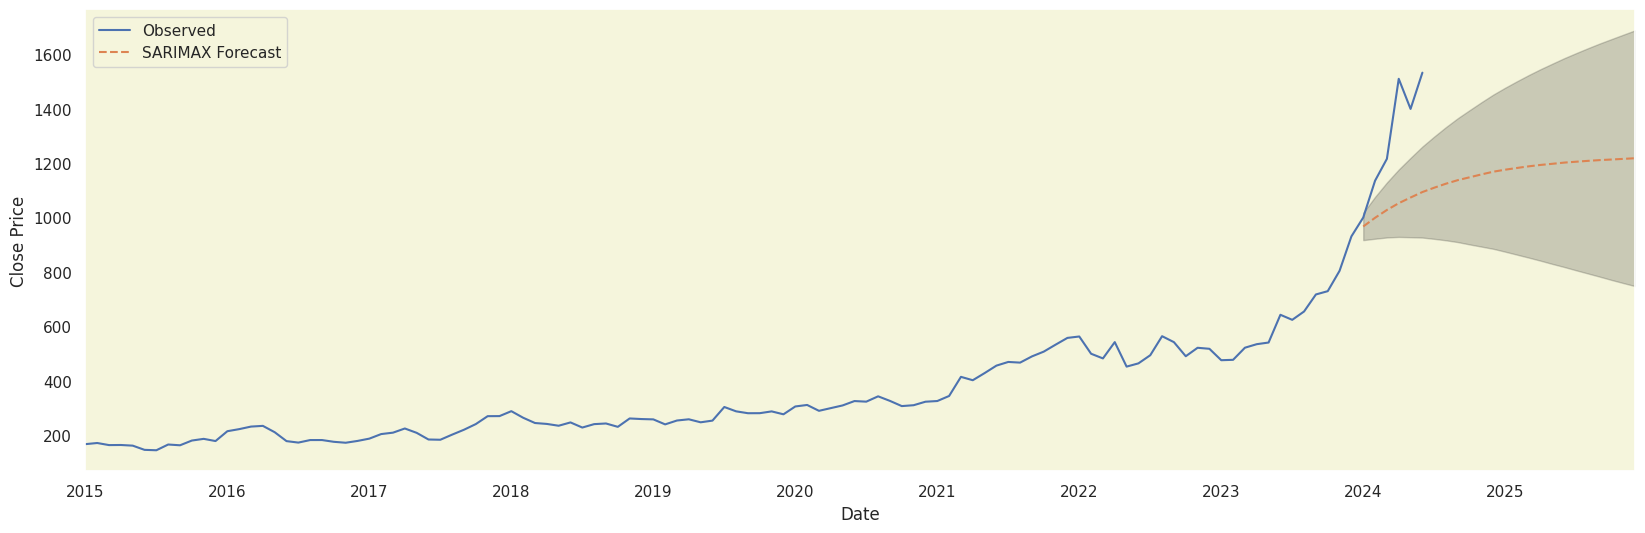

In [26]:
#Getting the SARIMAX forecast with number of steps as 24 since we want to make 2 year prediction and our data is monthly sampled.
pred = fitted_model.get_forecast(steps = 24)
#Plotting the observed and forecasted values:
ax1 = y['2015':].plot(label = 'Observed')
pred.predicted_mean.plot(ax = ax1, label = 'SARIMAX Forecast', figsize = (20, 6), linestyle = 'dashed')
#Finding the confidence intervals of the forecasts.
pred_ci = pred.conf_int()
ax1.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color = 'k', alpha = 0.2)
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price')
plt.legend(loc = 'upper left')
plt.show()

In [27]:
y_forecasted_SARIMAX = pred.predicted_mean
y_truth = test
mse_SARIMAX = ((y_forecasted_SARIMAX - y_truth) ** 2).mean()
print('The Mean Squared Error of SARIMAX forecast is {}'.format(round(mse_SARIMAX, 2)))
print('The Root Mean Squared Error of SARIMAX forecast is {}'.format(round(np.sqrt(mse_SARIMAX), 2)))

The Mean Squared Error of SARIMAX forecast is 93932.4
The Root Mean Squared Error of SARIMAX forecast is 306.48


https://www.kaggle.com/code/pythonafroz/day-ahead-electricity-price-prediction-with-lstm/notebook

In [28]:
df = df.dropna(how='all')

In [29]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,Diff_Close
Date,,,,,,,
2008-01-02,191.000000,196.399994,187.100006,190.500000,154.588120,165112.0,NaN
2008-01-03,190.000000,228.600006,188.649994,228.600006,185.505737,2655358.0,38.100006
2008-01-04,238.600006,269.899994,234.399994,250.500000,203.277298,3489837.0,21.899994
2008-01-07,246.699997,250.000000,232.500000,236.600006,191.997650,1062232.0,-13.899994
2008-01-08,240.000000,242.500000,209.949997,214.600006,174.144897,810699.0,-22.000000


In [30]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Diff_Close'], dtype='object')

In [31]:
df1 = df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
df1.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-01-02,191.000000,196.399994,187.100006,190.500000,154.588120,165112.0
2008-01-03,190.000000,228.600006,188.649994,228.600006,185.505737,2655358.0
2008-01-04,238.600006,269.899994,234.399994,250.500000,203.277298,3489837.0
2008-01-07,246.699997,250.000000,232.500000,236.600006,191.997650,1062232.0
2008-01-08,240.000000,242.500000,209.949997,214.600006,174.144897,810699.0


In [32]:
df2 = df1.reset_index('Date')
df2.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2008-01-02,191.000000,196.399994,187.100006,190.500000,154.588120,165112.0
1,2008-01-03,190.000000,228.600006,188.649994,228.600006,185.505737,2655358.0
2,2008-01-04,238.600006,269.899994,234.399994,250.500000,203.277298,3489837.0
3,2008-01-07,246.699997,250.000000,232.500000,236.600006,191.997650,1062232.0
4,2008-01-08,240.000000,242.500000,209.949997,214.600006,174.144897,810699.0


In [33]:
# Total Sum

import plotly.express as px 
import plotly.graph_objects as go
from plotly.subplots import make_subplots

df2['Date'] = pd.to_datetime(df2['Date'])

# Extract year from the 'Date' column
df2['Year'] = df2['Date'].dt.year

# Calculate total open price of shares for each year
yearly_open = df2.groupby('Year')['Open'].sum().reset_index()

# Create a pie chart with Plotly using a qualitative color palette
fig = px.pie(yearly_open, values='Open', names='Year', title='Total Open Price by Year',
             color_discrete_sequence=px.colors.qualitative.Prism)  # Using Prism color palette

# Customize layout
fig.update_layout(
    plot_bgcolor='rgb(17, 17, 17)',  # Dark background
    paper_bgcolor='rgb(17, 17, 17)',  # Dark background
    font_color="white",  # White text color
    title_font_color="white",  # White title color
)

# Show the plot
fig.show()

In [34]:
# Total Average

import plotly.express as px 
import plotly.graph_objects as go
from plotly.subplots import make_subplots

df2['Date'] = pd.to_datetime(df2['Date'])

# Extract year from the 'Date' column
df2['Year'] = df2['Date'].dt.year

# Calculate total open price of shares for each year
yearly_open = df2.groupby('Year')['Open'].mean().reset_index()

# Create a pie chart with Plotly using a qualitative color palette
fig = px.pie(yearly_open, values='Open', names='Year', title='Total Open Price by Year',
             color_discrete_sequence=px.colors.qualitative.Prism)  # Using Prism color palette

# Customize layout
fig.update_layout(
    plot_bgcolor='rgb(17, 17, 17)',  # Dark background
    paper_bgcolor='rgb(17, 17, 17)',  # Dark background
    font_color="white",  # White text color
    title_font_color="white",  # White title color
)

# Show the plot
fig.show()

In [35]:
# Group data by year and calculate the total open and close prices
yearly_prices = df2.groupby('Year').agg({'Open': 'sum', 'Close': 'sum'}).reset_index()

# Melt the DataFrame to convert it to long format for stack plot
yearly_prices_melted = pd.melt(yearly_prices, id_vars='Year', var_name='Price Type', value_name='Price')

# Create a bar chart with Plotly using custom colors
fig = px.bar(yearly_prices_melted, x='Year', y='Price', color='Price Type',
             title='Yearly Open and Close Prices',
             labels={'Price': 'Price ($)', 'Year': 'Year'},
             color_discrete_map={'Open': '#A2D9D9', 'Close': '#003737'})

# Customize layout
fig.update_layout(
    plot_bgcolor='rgb(240, 240, 240)',  # Light background
    paper_bgcolor='rgb(240, 240, 240)',  # Light background
    font_color="black",  # Black text color
    title_font_color="black",  # Black title color
)

# Show the plot
fig.show()

In [36]:
df = df.dropna(how='all')
df.head()

,Open,High,Low,Close,Adj Close,Volume,Diff_Close
Date,,,,,,,
2008-01-02,191.000000,196.399994,187.100006,190.500000,154.588120,165112.0,NaN
2008-01-03,190.000000,228.600006,188.649994,228.600006,185.505737,2655358.0,38.100006
2008-01-04,238.600006,269.899994,234.399994,250.500000,203.277298,3489837.0,21.899994
2008-01-07,246.699997,250.000000,232.500000,236.600006,191.997650,1062232.0,-13.899994
2008-01-08,240.000000,242.500000,209.949997,214.600006,174.144897,810699.0,-22.000000


In [37]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import plotly.graph_objects as go
import plotly.express as px 
from plotly.subplots import make_subplots

print(df2.isna().sum())  # This will display the count of missing values in each column

# Define custom color palette
custom_palette = ['#A2D9D9', '#73C5C5', '#009596', '#003737']  # Light greenish and purplish colors

# Function to handle missing values before decomposition (optional)
def handle_missing_values(data):
  # You can implement your preferred missing value handling method here (e.g., imputation, interpolation)
  # This example simply drops rows with missing values
  return data.dropna()

# Advanced-level plots with Plotly using the custom color palette

# 1. Candlestick chart
fig1 = go.Figure(data=[go.Candlestick(x=df2['Date'],
                                       open=df2['Open'],
                                       high=df2['High'],
                                       low=df2['Low'],
                                       close=df2['Close'])])
fig1.update_layout(title='Torent Power Stock Candlestick Chart')

# 2. Heatmap
fig2 = px.imshow(df2.corr(), color_continuous_scale=custom_palette)
fig2.update_layout(title='Correlation Heatmap')

# 3. 3D scatter plot
fig3 = px.scatter_3d(df2, x='Open', y='Close', z='Volume', color='Close',
                     title='3D Scatter Plot: Opening Price, Closing Price, and Volume',
                     color_continuous_scale=custom_palette)
fig3.update_traces(marker=dict(size=3))

# 4. Violin plot
fig4 = px.violin(df2, x='Year', y='Close', title='Violin Plot: Distribution of Closing Prices by Year',
                 color='Year', box=True, points="all", color_discrete_sequence=custom_palette)

# 5. Density Heatmap
fig5 = px.density_heatmap(df2, x='Date', y='Volume', title='Density Heatmap: Trading Volume over Time',
                          color_continuous_scale=custom_palette)
fig5.update_layout(coloraxis_colorbar=dict(title='Density'))

# 6. Time Series Decomposition
try:
  # Handle missing values before decomposition (optional)
  df_clean = handle_missing_values(df2['Close'])
  decomposition = seasonal_decompose(df_clean, model='additive', period=252)  # Assuming yearly seasonal period
except ValueError as e:
  if str(e) == "This function does not handle missing values":
    print("Error: Data contains missing values. Please handle missing values before decomposition.")
  else:
    raise e  # Re-raise other errors

fig6 = make_subplots(rows=4, cols=1, shared_xaxes=True, subplot_titles=('Original Series', 'Trend', 'Seasonal', 'Residual'))
fig6.add_trace(go.Scatter(x=df2['Date'], y=decomposition.observed, mode='lines', name='Original', line=dict(color=custom_palette[0])), row=1, col=1)
fig6.add_trace(go.Scatter(x=df2['Date'], y=decomposition.trend, mode='lines', name='Trend', line=dict(color=custom_palette[1])), row=2, col=1)
fig6.add_trace(go.Scatter(x=df2['Date'], y=decomposition.seasonal, mode='lines', name='Seasonal', line=dict(color=custom_palette[2])), row=3, col=1)
fig6.add_trace(go.Scatter(x=df2['Date'], y=decomposition.resid, mode='lines', name='Residual', line=dict(color=custom_palette[3])), row=4, col=1)
fig6.update_layout(title='Time Series Decomposition')

# 7. Pairwise Scatter Plot Matrix
fig7 = px.scatter_matrix(df2, dimensions=['Open', 'High', 'Low', 'Close', 'Volume'], color='Close',
                         title='Pairwise Scatter Plot Matrix', color_continuous_scale=custom_palette)


# Display the plots


# Display the plots
fig1.show()
fig2.show()
fig3.show()
fig4.show()
fig5.show()
fig6.show()
fig7.show()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Year         0
dtype: int64
